In [34]:
import pandas as pd
import plotnine as p9
import numpy as np
import math
import heapq
from statistics import mode 
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

In [35]:
data = pd.read_excel('Rice_Osmancik_Cammeo_Dataset.xlsx')

In [36]:
# normalize the seven quantitative columns to a mean of 0 and standard deviation 1.
for column in data[['AREA','PERIMETER','MAJORAXIS','MINORAXIS','ECCENTRICITY','CONVEX_AREA','EXTENT']]:
    data[column] = (data[column] - data[column].mean())/data[column].std()

In [37]:
data

,AREA,PERIMETER,MAJORAXIS,MINORAXIS,ECCENTRICITY,CONVEX_AREA,EXTENT,CLASS
0,1.479635,2.004091,2.348238,-0.212915,2.018073,1.499463,-1.152770,Cammeo
1,1.147720,1.125705,0.988261,0.945444,0.409964,1.192761,-0.602000,Cammeo
2,1.135020,1.317041,1.451718,0.253854,1.212797,1.126356,0.405558,Cammeo
3,0.293398,0.115285,0.261405,0.198025,0.239720,0.233826,-0.275315,Cammeo
4,1.166191,1.486858,1.316269,0.523351,0.952096,1.299685,-0.205986,Cammeo
...,...,...,...,...,...,...,...,...
3805,-0.708122,-1.078211,-1.048185,-0.097238,-1.085140,-0.745367,0.246999,Osmancik
3806,-0.601909,-0.922805,-1.207050,0.549550,-1.970472,-0.590047,0.418760,Osmancik
3807,-0.133186,-0.329808,-0.298206,0.085208,-0.275063,-0.173045,-0.455671,Osmancik
3808,-1.608046,-1.740092,-1.580764,-1.414228,-0.598743,-1.606945,-0.037163,Osmancik


In [38]:
# take the first seven columns and save into list column_name.
column_names = data.columns.values.tolist()
column_names.pop()

'CLASS'

In [39]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
data_reduced = pca.fit_transform(data[column_names])
pc0 = data_reduced[:, 0]
pc1 = data_reduced[:, 1]

In [40]:
pc0_list = pc0.tolist()
pc1_list = pc1.tolist()
df_pc0_pc1_class = pd.DataFrame({'PC0': pc0_list,'PC1': pc1_list,'Class': data['CLASS']})
df_pc0_pc1_class

,PC0,PC1,Class
0,3.812128,-2.165047,Cammeo
1,2.476833,0.045290,Cammeo
2,2.638209,-0.621534,Cammeo
3,0.547793,-0.151383,Cammeo
4,2.813662,-0.482400,Cammeo
...,...,...,...
3805,-1.932329,0.874176,Osmancik
3806,-1.813549,1.960078,Osmancik
3807,-0.436627,0.103581,Osmancik
3808,-3.587462,-0.375652,Osmancik


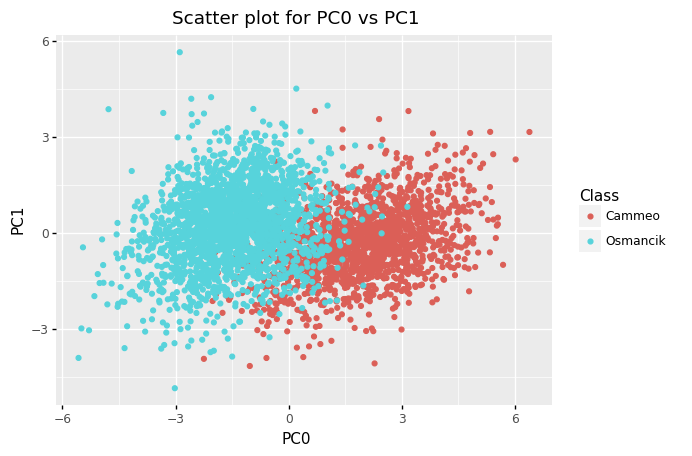

<ggplot: (112836064229)>

In [41]:
# use plotnine to draw the scatterplot between PC0 and PC1.
(p9.ggplot(data = df_pc0_pc1_class, mapping = p9.aes(x='PC0', y='PC1'))
+ p9.geom_point(p9.aes(x = 'PC0', y = 'PC1', color = 'Class'))
+ p9.labs(title = "Scatter plot for PC0 vs PC1"))

In [42]:
# reference: https://scipython.com/blog/quadtrees-2-implementation-in-python/
# set up a quad tree.
# associate data with point, each point contains data x, y, class.
class Point:
    def __init__(self, x, y, classes):
        self.x = x
        self.y = y
        self.classes = classes

# set up a tree data structure, in which each node represents a rectangle region.
# Rectangle is used to save the width, height of the quadtree.
class Rectangle:
    # (x, y) is the center of rectangule, wid is the 1/2 width of rectangule, hgt is the 1/2 height of rectangle.
    def __init__(self, x, y, wid, hgt):
        self.x = x
        self.y = y
        self.wid = wid
        self.hgt = hgt

    # validate whether the rectangle is within the circle, whose center point is point.x, point.y.
    def within(self, point, distance):
        def point_distance(x1, y1, x2, y2):
            value = (x1 - x2)**2 + (y1-y2)**2
            return math.sqrt(value)
        min_x = self.x - self.wid
        min_y = self.y - self.hgt
        max_x = self.x + self.wid
        max_y = self.y + self.hgt
        if point.x >= max_x:
            if point.y >= max_y:
                if (point_distance(max_x, max_y, point.x, point.y)) <= distance:
                    return True
                else: return False
            elif point.y <= min_y:
                if (point_distance(max_x, min_y, point.x, point.y)) < distance:
                    return True
                else: return False
            elif min_y < point.y < max_y:
                if (point_distance(max_x, 0, point.x, 0)) <= distance:
                    return True
                else: return False
        elif point.x <= min_x:
            if point.y >= max_y:
                if (point_distance(min_x, max_y, point.x, point.y)) < distance:
                    return True
                else: return False
            elif point.y <= min_y:
                if (point_distance(min_x, min_y, point.x, point.y)) < distance:
                    return True
                else: return False
            elif min_y <= point.y <= max_y:
                if (point_distance(min_x, 0, point.x, 0)) < distance:
                    return True
                else: return False
        elif min_x <= point.x <= max_x:
            if point.y >= max_y:
                if (point_distance(0, max_y, 0, point.y)) < distance:
                    return True
                else: return False
            elif point.y <= min_y:
                if (point_distance(0, min_y, 0, point.y)) < distance:
                    return True
                else: return False
            # validate whether a point is inside the rectangle region.
            elif min_y <= point.y <= max_y:
                return True

In [43]:
class QuadTree:
    # boundary used to store the detailed information about rectangule: width, height, center point.
    # max_point is the maximum number of points could be stored in the tree.
    # points_list include points stored in the tree.
    # subdivided is used to mark the tree status: whether it is subdivided.
    # upperleft, upperright, lowerleft, lowerright are subnodes stored under the parent node in the tree.
    def __init__(self, boundary, points_list, max_point):
        self.boundary = boundary
        self.points_list = points_list
        self.max_point = max_point
        self.isleaf = False
        self.subdivided = False
        self.upperleft, self.upperright, self.lowerleft, self.lowerright = None, None, None, None
        self.construct()

    def subdivide(self):
        x = self.boundary.x
        y = self.boundary.y
        wid = self.boundary.wid
        hgt = self.boundary.hgt
        # divide this node into four children nodes, whose boundaries are northwest, northeast, southeast, southwest direction within the boundary of current node.
        upperright = Rectangle(x + wid/2, y + hgt/2, wid/2, hgt/2)
        upperleft = Rectangle(x - wid/2, y + hgt/2, wid/2, hgt/2)
        lowerleft = Rectangle(x - wid/2, y - hgt/2, wid/2, hgt/2)
        lowerright = Rectangle(x + wid/2, y - hgt/2, wid/2, hgt/2)
        upperright_point, upperleft_point, lowerright_point, lowerleft_point = [], [], [], []
        for point in self.points_list:
            if point.x > x and point.y >= y:
                upperright_point.append(point)
        for point in self.points_list:
            if point.x <= x and point.y >= y:
                upperleft_point.append(point)
        for point in self.points_list:
            if point.x <= x and point.y < y:
                lowerleft_point.append(point)
        for point in self.points_list:
            if point.x > x and point.y < y:
                lowerright_point.append(point)
        self.upperright = QuadTree(upperright, upperright_point, self.max_point)
        self.upperleft = QuadTree(upperleft, upperleft_point, self.max_point)
        self.lowerleft = QuadTree(lowerleft, lowerleft_point, self.max_point)
        self.lowerright = QuadTree(lowerright, lowerright_point, self.max_point)

    def construct(self):
        if len(self.points_list) > self.max_point:
            # if not subdivided(subdivided = False), then run subdivide.
            if self.subdivided is False:
                self.subdivide()
                self.subdivided = True
                self.points_list = []
        else:
            # if all the points in the points_list have been added into the quadtree, then stop subdivide.
            self.isleaf = True
            return True

In [44]:
# KNN function takes a quadtree, point list and number k.
def KNN(quadtree, pnt, k):     
    res = []
    for p in pnt:
        # save quadtree into a stack.
        stack = [quadtree]
        r = (float('-inf'),"")
        point_list = []
        # reference: https://www.fatalerrors.org/a/k-nearest-neighbor-query-based-on-k-dimension-tree-of-knn-algorithm.html
        while len(stack):
            current_node = stack.pop(-1)
            if current_node.isleaf is True and current_node.boundary.within(p, -r[0]) is True:
                for i in current_node.points_list:
                        # reference: https://docs.python.org/3/library/heapq.html
                        # use heapq algorithm, to efficiently sort the queue.
                        if len(point_list) < k:
                            distance = math.sqrt((i.x - p.x)**2+(i.y - p.y)**2)
                            heapq.heappush(point_list,(-distance, i.classes))
                            r = heapq.nsmallest(1, point_list)[0]
                        elif math.sqrt((i.x - p.x)**2 + (i.y - p.y)**2) < -r[0]:
                            distance = math.sqrt((i.x - p.x)**2 + (i.y - p.y)**2)
                            heapq.heappop(point_list)
                            heapq.heappush(point_list, (-distance, i.classes))
                            r = heapq.nsmallest(1,point_list)[0]
            elif current_node.isleaf is False:
                if current_node.boundary.within(p, -r[0]):
                    if current_node.upperleft is not None:
                        stack.append(current_node.upperleft)
                    if current_node.lowerright is not None:
                        stack.append(current_node.lowerright)
                    if current_node.upperright is not None:
                        stack.append(current_node.upperright)
                    if current_node.lowerleft is not None:
                        stack.append(current_node.lowerleft)
       
        # use mode() to find the most frequent element.
        res.append(mode([itr[1] for itr in point_list]))
    return res 

In [45]:
# reference: https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/
# Testing: implement naive KNN method to test the result.

# calculate euclidean distance between each train row and new test row.
def euclidean_distance(row1, row2):
    distance = 0.0
    # i is the index to a specific column, calculate euclidean distance of each data from row1 and row2, and sum up. 
    for i in range(len(row1)-1):
        distance += (row1[i] - row2[i])**2
    return math.sqrt(distance)
 
# sort all of the records in the training dataset by their distance to new data, return top k similar neighbors.
def get_neighbors(train, test_row, num_neighbors):
    # save distance for each record in the dataset as a tuple, sort the list of tuples by distance in descending order.
    distances = list()
    for train_row in train:
        dist = euclidean_distance(test_row, train_row)
        distances.append((train_row, dist))
    # sort tuple distance based on euclidean distance.
    distances.sort(key=lambda tup: tup[1])
    neighbors = list()
    # retrieve the neighbors.
    for i in range(num_neighbors):
        neighbors.append(distances[i][0])
    return neighbors

# return the most represented class among the neighbors.
def classification(train, test_row, num_neighbors):
    neighbors = get_neighbors(train, test_row, num_neighbors)
    output_values = [row[-1] for row in neighbors]
    # max() takes a set of unique class values. for each class value in the set, calls the count on the list of class values.
    prediction = max(set(output_values), key=output_values.count)
    return prediction
    
# cross-validation of KNN.
def cross_validation(train, test, num_neighbors):
    predictions = list()
    for row in test:
        output = classification(train, row, num_neighbors)
        predictions.append(output)
    return(predictions) 

In [46]:
def show_matrix(k):
    kfold_data = KFold(5)
    result_quadtree = []
    result_true = []
    result_naive = []
    # reference: https://www.askpython.com/python/examples/k-fold-cross-validation
    X = data.loc[:, data.columns!='CLASS']
    y = data['CLASS']
    for train_index, test_index in kfold_data.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        data_reduced = pca.fit_transform(X_train[column_names])
        test_data_reduced = pca.transform(X_test[column_names])
        pc0 = data_reduced[:, 0]
        test_pc1 = test_data_reduced[:, 1]
        test_pc0 = test_data_reduced[:, 0]
        pc1 = data_reduced[:, 1]       
        xlim_min = min(pc0)
        ylim_min = min(pc1)
        xlim_max = max(pc0)
        ylim_max = max(pc1)

        boundary = Rectangle((xlim_max + xlim_min)/2, (ylim_max + ylim_min)/2, (xlim_max - xlim_min)/2, (ylim_max - ylim_min)/2)
        quadtree = QuadTree(boundary,[Point(pc0[k],pc1[k], y_train.iloc[k]) for k in range(len(pc0))], 10)
        knn_result = KNN(quadtree,[Point(test_pc0[k], test_pc1[k], y_test.iloc[k]) for k in range(len(test_pc0))], k)
        y_pred = cross_validation(list(zip(pc1, pc0, y_train)), list(zip(test_pc1, test_pc0, y_test)), k)

        result_quadtree = result_quadtree + knn_result
        result_true = result_true + y_test.to_list()
        result_naive = result_naive + y_pred
        
        
    print("The confusion matrix of k nearest neighbors based on quad tree data structure is:")    
    print(confusion_matrix(result_true, result_quadtree))
    print("The confusion matrix of naive k nearest neighbors is:") 
    print(confusion_matrix(result_true, result_naive))

In [47]:
show_matrix(1)

The confusion matrix of k nearest neighbors based on quad tree data structure is:
[[1335  295]
 [ 261 1919]]
The confusion matrix of naive k nearest neighbors is:
[[1335  295]
 [ 261 1919]]


In [48]:
show_matrix(5)

The confusion matrix of k nearest neighbors based on quad tree data structure is:
[[1388  242]
 [ 211 1969]]
The confusion matrix of naive k nearest neighbors is:
[[1388  242]
 [ 211 1969]]
